In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, ZeroPadding2D, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.16.1


In [4]:
# **Data Loading and Preprocessing**

# Use a consistent file path format (e.g., os.path.join)
furniture_df = pd.read_csv(os.path.join("..", "furniture_data.csv"))
furniture_sliding_df = pd.read_csv(os.path.join("..", "furniture_sliding_data.csv"))
full_furniture_df = pd.concat([furniture_df, furniture_sliding_df], axis=0)

In [5]:
categorical_folders = full_furniture_df["Furniture_Category"].unique()  # Use the full dataframe
print(categorical_folders)

['beds' 'chairs' 'dressers' 'lamps' 'sofas' 'tables']


In [6]:
num_classes = full_furniture_df["Furniture_Category"].nunique()
print("Number of classes:", num_classes)

Number of classes: 6


In [7]:
dev, test = train_test_split(full_furniture_df, train_size=0.85, shuffle=True, random_state=333)
print(dev.shape, test.shape)

(355893, 3) (62805, 3)


In [8]:
# **Constants and Hyperparameters**

BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [9]:
# **Data Augmentation**

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=40,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.6, 1.2],
    fill_mode='nearest',
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
# **Data Generators**

train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',  
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(train_ds.class_indices)

Found 64980 validated image filenames belonging to 6 classes.
Found 11466 validated image filenames belonging to 6 classes.
Found 13636 validated image filenames belonging to 6 classes.
{'beds': 0, 'chairs': 1, 'dressers': 2, 'lamps': 3, 'sofas': 4, 'tables': 5}


(32, 224, 224, 3)
(32, 6)
Label:  [0. 1. 0. 0. 0. 0.]


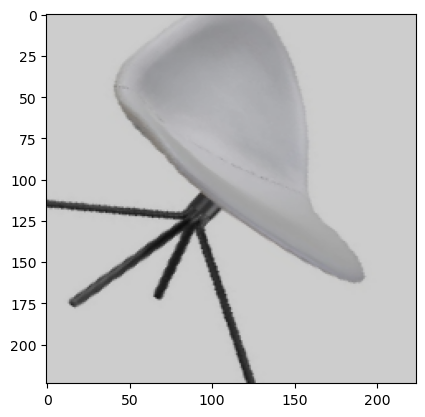

Label:  [0. 1. 0. 0. 0. 0.]


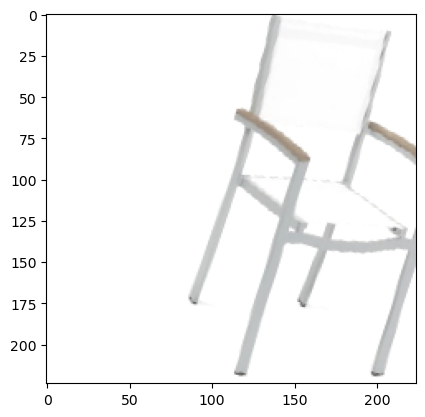

Label:  [1. 0. 0. 0. 0. 0.]


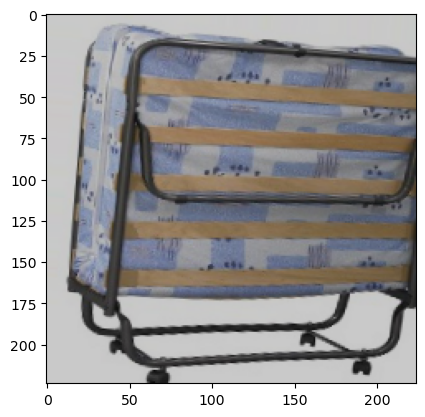

In [11]:
# **Visualize Augmented Data**

batchX, batchY = train_ds.__next__()
print(batchX.shape)
print(batchY.shape)

for i in range(3):
    img = batchX[i]
    label = batchY[i]
    print('Label: ', label)
    plt.imshow(img)
    plt.show()

In [12]:
# **Model Definition**

model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 

    Flatten(),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,038 (12.47 MB)

 Trainable params: 3,268,038 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# **Model Compilation**

optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimization, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [15]:
# **Callbacks**

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=15, 
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001
)

In [16]:
# **Model Training**

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5,  
    batch_size=BATCH_SIZE, 
    callbacks=[early_stopping_callback]
)

Epoch 1/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1032s 506ms/step - accuracy: 0.6076 - loss: 1.0597 - val_accuracy: 0.8040 - val_loss: 0.5787
Epoch 2/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1030s 506ms/step - accuracy: 0.8030 - loss: 0.5699 - val_accuracy: 0.8430 - val_loss: 0.4693
Epoch 3/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1006s 494ms/step - accuracy: 0.8367 - loss: 0.4803 - val_accuracy: 0.8512 - val_loss: 0.4432
Epoch 4/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1026s 504ms/step - accuracy: 0.8522 - loss: 0.4279 - val_accuracy: 0.8679 - val_loss: 0.3833
Epoch 5/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1023s 503ms/step - accuracy: 0.8636 - loss: 0.4014 - val_accuracy: 0.8764 - val_loss: 0.3699
Restoring model weights from the end of the best epoch: 5.


In [20]:
# **Model Evaluation**

# 1. Predict classes on the test set
y_pred_prob = model.predict(test_ds)  
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class labels with highest probability

427/427 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step


In [21]:
# 2. Get true labels from the test set
y_true = test_ds.classes 

In [22]:
# 3. Calculate metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [23]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8996


In [24]:
# Precision, Recall, and F1-score (consider micro-averaging for multi-class)
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

In [25]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8996
Recall: 0.8996
F1-score: 0.8996


In [26]:
# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 807  103   23    6   20   34]
 [  37 3042   13   45  120   60]
 [  15   52 1047   11   35   47]
 [  18  115   21 4686    7  103]
 [   6   36    1    2  535    1]
 [  45  160   91  112   30 2150]]


In [27]:
# 5. Classification Report 
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_ds.class_indices.keys()))) 

Classification Report:
              precision    recall  f1-score   support

        beds       0.87      0.81      0.84       993
      chairs       0.87      0.92      0.89      3317
    dressers       0.88      0.87      0.87      1207
       lamps       0.96      0.95      0.96      4950
       sofas       0.72      0.92      0.81       581
      tables       0.90      0.83      0.86      2588

    accuracy                           0.90     13636
   macro avg       0.86      0.88      0.87     13636
weighted avg       0.90      0.90      0.90     13636



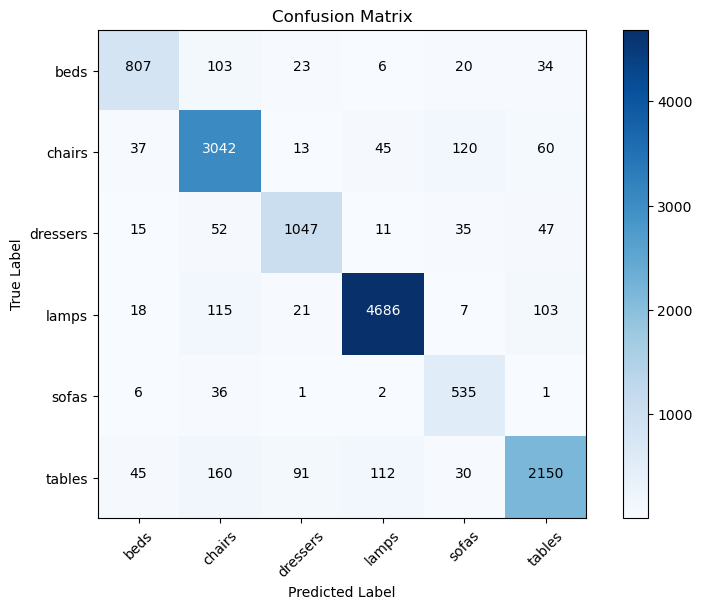

In [28]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(train_ds.class_indices))
plt.xticks(tick_marks, train_ds.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, train_ds.class_indices.keys())

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

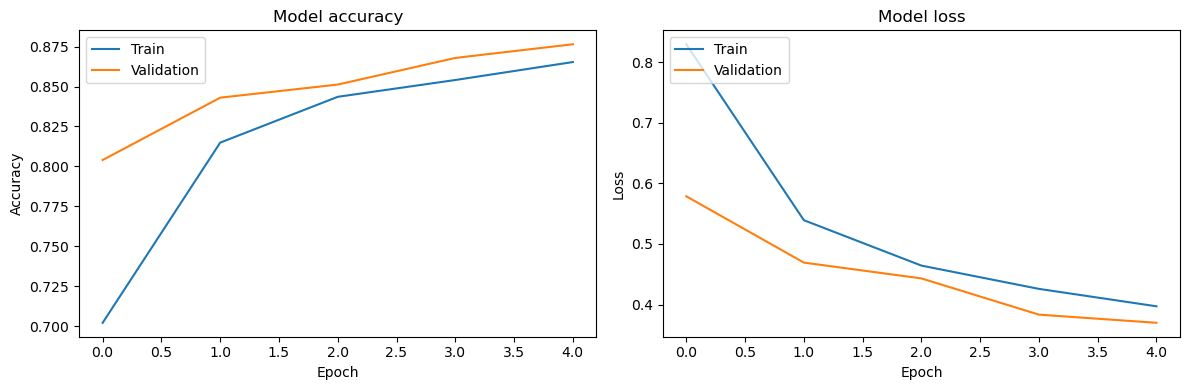

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.save('../TrainingModels/self_built_model1.keras')